# MovieLens - Ingestion Batch et Vérification de la Qualité


# ETL Pipeline - MovieLens Dataset avec PySpark


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
import os
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Initialisation de Spark


In [2]:
spark = SparkSession.builder \
    .appName("BatchETL") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()
    
spark.sparkContext.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/30 11:11:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/30 11:11:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## 2. Chargement des fichiers CSV depuis HDFS


In [3]:
ratings_path = "hdfs://namenode:9000/user/movielens/raw/rating.csv"
movies_path = "hdfs://namenode:9000/user/movielens/raw/movie.csv"

ratings_df = spark.read.option("header", True).option("inferSchema", True).csv(ratings_path)
movies_df = spark.read.option("header", True).option("inferSchema", True).csv(movies_path)

In [4]:
# Affichage des schémas
print("Schéma des notes:")
ratings_df.printSchema()

print("\nSchéma des films:")
movies_df.printSchema()

Schéma des notes:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)


Schéma des films:
root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



## 3. Vérification de la qualité des données


In [5]:

def count_nulls(df):
    exprs = []
    for c in df.columns:
        dtype = dict(df.dtypes)[c]
        if dtype in ["float", "double"]:
            exprs.append(count(when(col(c).isNull() | isnan(col(c)), c)).alias(c))
        else:
            exprs.append(count(when(col(c).isNull(), c)).alias(c))
    return df.select(exprs)

In [6]:
# Suppression des valeurs nulles
ratings_df = ratings_df.dropna()
movies_df = movies_df.dropna()

In [7]:
# Suppression des doublons
ratings_df = ratings_df.dropDuplicates()
movies_df = movies_df.dropDuplicates()

In [8]:
# Vérification des valeurs manquantes
print("Valeurs manquantes dans les notes:")
count_nulls(ratings_df).show()

print("\nValeurs manquantes dans les films:")
count_nulls(movies_df).show()


Valeurs manquantes dans les notes:


+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+


Valeurs manquantes dans les films:
+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+



## 4. Visualisation de la distribution des notes

In [9]:
# Conversion en pandas pour la visualisation
ratings_pandas = ratings_df.select("rating").limit(50000).toPandas()

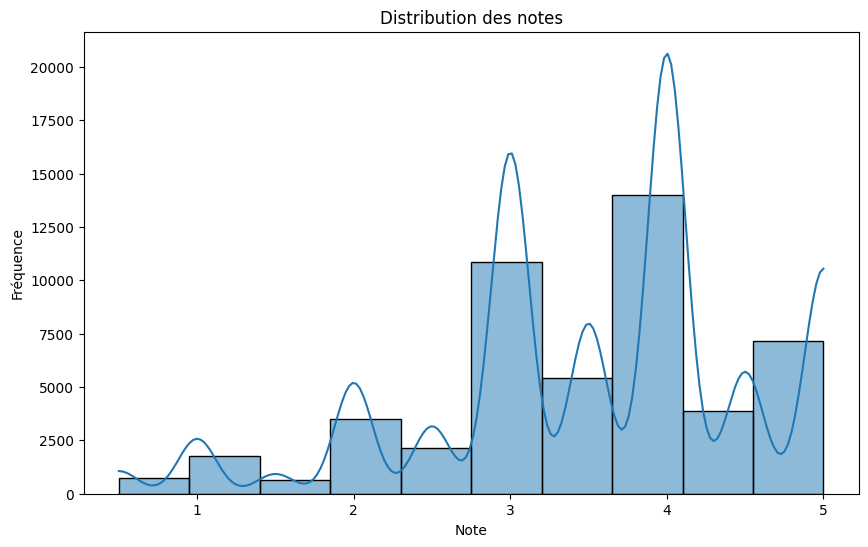

In [10]:
# Distribution des notes
plt.figure(figsize=(10, 6))
sns.histplot(ratings_pandas["rating"], bins=10, kde=True)
plt.title('Distribution des notes')
plt.xlabel('Note')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
# Filtrage des notes extrêmes
ratings_df = ratings_df.filter((col("rating") >= 0.5) & (col("rating") <= 5.0))

# Jointure pour enrichir les données
ratings_enriched_df = ratings_df.join(movies_df, on="movieId", how="inner")

# Partitionnement par userId et sauvegarde dans HDFS (parquet)
ratings_enriched_df.repartition(8) \
    .write \
    .mode("overwrite") \
    .partitionBy("userId") \
    .parquet("hdfs://namenode:9000/user/movielens/clean/ratings_by_user")

print("\n✅ Pipeline ETL terminé. Données sauvegardées dans /user/movielens/clean/ratings_by_user")

[Stage 27:>                                                         (0 + 8) / 8]